In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
import numpy as np
import pandas as pd
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
import collections
from collections import Counter

def load_features(name_lst, file_addr_x, file_addr_y):
    '''
    Loading features.
    name_lst: The size of time window used for segmenting features
    file_addr_x: The address of feature files
    file_addr_y: The address of label files
    '''
    x_test = []
    y_test = []
    for i in range(len(name_lst)):
        k = list(name_lst.keys())[i]
        v = list(name_lst.values())[i]
        X_all = pd.read_csv(file_addr_x+str(k)+"_"+str(v)+".csv")
        x_test.append(X_all)
        y_all = np.loadtxt(file_addr_y+str(k)+'_'+str(v)+'.out')
        y_all_new = []
        #y_test.extend(y_all)
        count = 0
        for y in y_all:
            if y > 30:
                y = 30
                y_all_new.append(y)
                count+=1
            else:
                y_all_new.append(y)
        y_test.extend(y_all_new) 
        #y_test.extend(y_all) 
        
    return x_test, y_test

def merge_data(data_lst):
    # Merge the data in data_lst 
    pd_data = pd.DataFrame(data_lst[0])
    for i in range(1, len(data_lst)):
        pd_data = pd.concat([pd_data,data_lst[i]], ignore_index = True)
    return pd_data

def get_index(T_num_list, addr_idx):
    # get the file indexes in order(each file includes data of one day) 
    index_s=[]
    for i in range(len(T_num_list)):
        k = list(T_num_list.keys())[i]
        v = list(T_num_list.values())[i]
        index = np.loadtxt(addr_idx + str(k)+'_'+str(v)+'.out')
        index_n = []
        new=0
        for i in index:
            new+=int(i)
            index_n.append(new)
        index_s.append(index_n)
    return index_s

/Users/liujianqiao/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#Load all FIU data
x_research, y_research = load_features({10:0},"new_webresearch/new_webresearch_X_", "new_webresearch/new_webresearch_y_")
x_users, y_users = load_features({10:0},"new_webusers/new_webusers_X_", "new_webusers/new_webusers_y_")
x_webmail, y_webmail = load_features({10:0}, "new_webmail/new_webmail_X_","new_webmail/new_webmail_y_")
x_local_10, y_local_10 = load_features({10:0},"new_online/new_online_x_", "new_online/new_online_y_")
x_home1, y_home1 = load_features({10:0}, "new_home1/new_home1_X_","new_home1/new_home1_y_")
x_home2, y_home2 = load_features({10:0}, "new_home2/new_home2_X_","new_home2/new_home2_y_")
x_home3, y_home3 = load_features({10:0}, "new_home3/new_home3_X_","new_home3/new_home3_y_")
x_home4, y_home4 = load_features({10:0}, "new_home1/new_home1_X_","new_home1/new_home1_y_")
#Merge all FIU data
lst = []
lst.append(merge_data(x_research))
lst.append(merge_data(x_users))
lst.append(merge_data(x_webmail))
lst.append(merge_data(x_local_10))
lst.append(merge_data(x_home1))
lst.append(merge_data(x_home2))
lst.append(merge_data(x_home3))
lst.append(merge_data(x_home4))
x_train_all = merge_data(lst)

y_train_all = []
y_train_all.extend(y_research)
y_train_all.extend(y_users)
y_train_all.extend(y_webmail)
y_train_all.extend(y_local_10)
y_train_all.extend(y_home1)
y_train_all.extend(y_home2)
y_train_all.extend(y_home3)
y_train_all.extend(y_home4)
print(len(x_train_all), len(y_train_all))

20781 20781


In [7]:
idx = []
idx2 = []
for i in range(len(y_train_all)):
    if y_train_all[i]==30:
        idx.append(i) 
    if y_train_all[i]==2:
        idx2.append(i)
#'delta_time__number_cwt_peaks'
#delta_time__count_above_mean
#delta_time__longest_strike_below_mean
a = [col for col in x_train_all.columns if 'delta_time__longest_strike_below_mean' in col]
df1 = x_train_all[a[0]]

ar_30 = df1.iloc[idx]
ar_2 = df1.iloc[idx2]

ar_30 = list(ar_30)
ar_2 = list(ar_2)
print(len(ar_30),len(ar_2))
leng = min(len(ar_30), len(ar_2))

print(leng)


81 10690
81


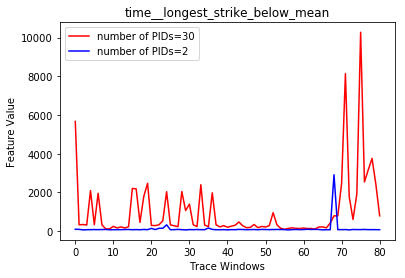

In [8]:
#Get the figures of features 
import matplotlib.pyplot as plt
plt.title('time__longest_strike_below_mean')
plt.plot(ar_30[:leng], color='red', label='number of PIDs=30')
plt.plot(ar_2[:leng], color='blue', label='number of PIDs=2')
plt.legend()

plt.xlabel('Trace Windows')
plt.ylabel('Feature Value')
plt.show()
# figure example

In [9]:
idx = []
idx2 = []
for i in range(len(y_train_all)):
    if y_train_all[i]==30:
        idx.append(i) 
    if y_train_all[i]==2:
        idx2.append(i)
#'delta_time__number_cwt_peaks'
#delta_time__count_above_mean
#delta_time__longest_strike_below_mean
a = [col for col in x_train_all.columns if 'delta_time__number_cwt_peaks' in col]
df1 = x_train_all[a[0]]

ar_30 = df1.iloc[idx]
ar_2 = df1.iloc[idx2]

ar_30 = list(ar_30)
ar_2 = list(ar_2)
print(len(ar_30),len(ar_2))
leng = min(len(ar_30), len(ar_2))

print(leng)


81 10690
81


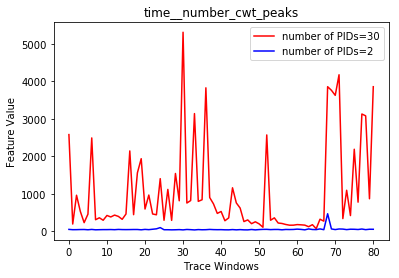

In [10]:
#Get the figures of features 
import matplotlib.pyplot as plt
plt.title('time__number_cwt_peaks')
plt.plot(ar_30[:leng], color='red', label='number of PIDs=30')
plt.plot(ar_2[:leng], color='blue', label='number of PIDs=2')
plt.legend()

plt.xlabel('Trace Windows')
plt.ylabel('Feature Value')
plt.show()
# figure example